## Fine-Tuning to Follow Instructions

This notebook covers Chapter 7 of [*Build a Large Language Model from Scratch*](https://www.manning.com/books/build-a-large-language-model-from-scratch) by Sebastian Raschka (2025).

---

### Assemble the Model

Bring in all the parts:

In [1]:
import torch
import torch.nn as nn
import tiktoken

# tokenizer:
tokenizer = tiktoken.get_encoding("gpt2")

# LayerNorm:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # small constant to prevent division by 0 errors:
        self.eps = 1e-5

        # trainable parameters to scale and shift weights
        # if model feels that doing so will improve 
        # the training:
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mu = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # no Bessel correction (n-1)
        norm_x = (x - mu) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

# GELU:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

# feed forward:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
            GELU(),
            nn.Linear(4 * config["emb_dim"], config["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

# multi-head attention:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        # logic check:
        assert (d_out % num_heads == 0), "Error: d_out must be divisible by num_heads!"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # final embedding size

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # linear layer for head outputs
        # (not strictly necessary, but commonly used):
        self.out_proj = nn.Linear(d_out, d_out)

        # dropout:
        self.dropout = nn.Dropout(dropout)

        # register buffer:
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, d_in = x.shape

        # queries, keys, values
        # of shape (batch_size, num_tokens, d_out):
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)
        
        # split the matrices:
        queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)

        # transpose from (batch_size, num_tokens, num_heads, head_dim)
        # to (batch_size, num_heads, num_tokens, head_dim):
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # attention scores:
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # mask
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        # context vectors:
        context_vec = (attn_weights @ values).transpose(1, 2) # (1, 2) --> (num_tokens, num_heads)
        context_vec = context_vec.contiguous().view( # tensor of shape (batch_size, num_tokens, num_heads, head_dim)
            batch_size, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)
        return context_vec

# transformer block:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        # attention:
        self.attention = MultiHeadAttention(
            d_in=config["emb_dim"],
            d_out=config["emb_dim"],
            context_length=config["context_length"],
            num_heads=config["n_heads"],
            dropout=config["drop_rate"],
            qkv_bias=config["qkv_bias"]
        )

        # feed forward:
        self.ff = FeedForward(config)

        # norm:
        self.norm1 = LayerNorm(config["emb_dim"])
        self.norm2 = LayerNorm(config["emb_dim"])
        
        # dropout with shortcut:
        self.drop_shortcut = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        shortcut = x

        # pre-layer norm:
        x = self.norm1(x)

        # attention:
        x = self.attention(x)

        # dropout with shortcut:
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x

        # pre-layer norm:
        x = self.norm2(x)

        # feed forward network:
        x = self.ff(x)

        # dropout with shortcut:
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

# GPT model:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # token embeddings of shape (n_tokens, embedding_dims):
        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])

        # positional embeddings of shape (context_length, embedding_dims):
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])

        # dropout:
        self.drop_emb = nn.Dropout(config["drop_rate"])

        # N transformer blocks (corresponds to n_layers):
        self.trf_blocks = nn.Sequential(
            *[
                TransformerBlock(config) for _
                in range(config["n_layers"])
            ]
        )

        # normalization:
        self.final_norm = LayerNorm(config["emb_dim"])

        # final output head:
        self.out_head = nn.Linear(
            config["emb_dim"], config["vocab_size"], bias=False
        )

    # forward pass:
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        token_embeddings = self.tok_emb(in_idx)
        pos_embeddings = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        
        x = token_embeddings + pos_embeddings
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        
        logits = self.out_head(x)
        return logits

Helper functions:

In [2]:
import numpy as np

# helper function for assigning weights:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch! Left: {left.shape} | Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


# function for loading the weights:
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        # divide attention and bias weights into three equal parts for Q,K,V:
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)

        gpt.trf_blocks[b].attention.W_query.weight = assign(gpt.trf_blocks[b].attention.W_query.weight, q_w.T) 
        gpt.trf_blocks[b].attention.W_key.weight = assign(gpt.trf_blocks[b].attention.W_key.weight, k_w.T) 
        gpt.trf_blocks[b].attention.W_value.weight = assign(gpt.trf_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)

        gpt.trf_blocks[b].attention.W_query.bias = assign(gpt.trf_blocks[b].attention.W_query.bias, q_b) 
        gpt.trf_blocks[b].attention.W_key.bias = assign(gpt.trf_blocks[b].attention.W_key.bias, k_b) 
        gpt.trf_blocks[b].attention.W_value.bias = assign(gpt.trf_blocks[b].attention.W_value.bias, v_b)

        gpt.trf_blocks[b].attention.out_proj.weight = assign(
            gpt.trf_blocks[b].attention.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].attention.out_proj.bias = assign(
            gpt.trf_blocks[b].attention.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])

    # reuse the token embeddings weights ("weight tying"):
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


# text generation:
def generate(model, idx, max_new_tokens,
             context_size, temperature=0.0,
             top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        # top K:
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float("-inf")).to(logits.device),
                logits
            )
        # temperature scaling:
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        # truncate to only the last N tokens in the context_size:
        idx_cond = idx[:, -context_size:]
        
        # predict:
        with torch.no_grad():
            logits = model(idx_cond)
        
        # focus on the last step
        # (batch, vocab_size):
        logits = logits[:, -1, :]

        # get probabilities:
        probs = torch.softmax(logits, dim=-1)

        # get next token index with the highest probability:
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)

        # append next token to previous inputs:
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


# text to token IDs:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # un-squeezing adds batch dimension
    return encoded_tensor


# token IDs to text:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # squeezing removes the batch dimension
    return tokenizer.decode(flat.tolist())

Training functions:

In [3]:
# loss:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0. # cumulative loss
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss
        else:
            break
    return total_loss / num_batches # average loss across all batches

# function for evaluation:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )

        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss


# function for printing examples during training:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))


# function for training:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses = []
    val_losses = []
    track_tokens_seen = []

    tokens_seen = 0
    global_step = -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            # reset gradients:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            # loss gradients:
            loss.backward()

            # update weights with gradients:
            optimizer.step()

            # update seen tokens:
            tokens_seen += input_batch.numel()
            global_step += 1

            # eval step:
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch: {epoch+1} (Step {global_step:06d})")
                print(f"Training loss: {train_loss:.3f}")
                print(f"Validation loss: {val_loss:.3f}")
                print(f"-"*30)
            
            # print example:
            generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

### Preparing a dataset for supervised instruction fine-tuning

Pretrained LLMs are capable of text completion, but they often struggle to follow specific instructions (e.g., "Fix the grammar in this sentence). 

To accomplish specific instruction tasks, the model will need to  fine-tuned on ***instruction-response pairs***.

Let's fetch a dataset:

In [4]:
import json
import os
import urllib.request

# download function:
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as res:
            text_data = res.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(text_data)
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

# get data:
file_path = "instruction-data.json"
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
       "/main/ch07/01_main-chapter-code/instruction-data.json")

data = download_and_load_file(file_path, url)
print(f"Number of observations: {len(data)}")
print(f"Example:\n {data[50]}")

Number of observations: 1100
Example:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


Occasionally, an input may be empty, but there is still an instruction and an output:

In [5]:
for k,v in data[999].items():
    print(f"{k}: {v}")

instruction: What is an antonym of 'complicated'?
input: 
output: An antonym of 'complicated' is 'simple'.


There are other ways to format the data too, such as ***Alpaca*** prompt style and ***Phi-3*** prompt style:

**Alpaca:**

```text
Below is an instruction the describes a task. Write a response
that that appropriately comples the request.

### Instruction
Identify the correct spelling of the following word.

### Input:
Occasion

### Response:
The correct spelling is 'Occasion'.

```

**Phi-3:**
```text
<|user|>
Identify the correct spelling of the following word: 'Occasion'

<|assistant|>
The correct spelling is 'Occasion'.
```

Here, we'll use Alpaca style:

In [6]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )

    return instruction_text + input_text

Check it out:

In [7]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [8]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
The correct spelling is 'Occasion.'


Let's prepare the data for training:

In [9]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.10)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print(f"{len(train_data)} training examples")
print(f"{len(val_data)} validation examples")
print(f"{len(test_data)} testing examples")

935 training examples
55 validation examples
110 testing examples


### Organizing into training batches

We'll need to create our own custom collate function for instruction fine-tuning.
- Data collators help turn examples into batches for efficient processing.

In [10]:
from torch.utils.data import Dataset

# dataset:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)
        
        
# data collator:
def custom_collate_draft_1(
        batch,
        pad_token_id=50256,
        device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id]*
            (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    input_tensor = torch.stack(inputs_lst).to(device)
    return input_tensor


Test the data collator:

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (inputs_1, inputs_2, inputs_3)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


What's missing are the corresponding token IDs for the ***targets***.
- As previously learned, the target token IDs are the input token IDs *shifted one position right*. 
- We'll add this to our data collator.

In [12]:
def custom_collate_draft_2(
        batch,
        pad_token_id=50256,
        device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id]*
            (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    input_tensor = torch.stack(inputs_lst).to(device)
    target_tensor = torch.stack(targets_lst).to(device)
    return input_tensor, target_tensor

Test:

In [13]:
inputs, targets = custom_collate_draft_2(batch)
print(f"Inputs:\n{inputs}")
print(f"Targets:\n{targets}")

Inputs:
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Targets:
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


Lastly, we need to replace (*all but one of*) the `<|endoftext|>` token in the target list wth `-100`. 
- This prevents padding tokens from contributing to training loss.
- Only useful tokens will therefore influence model training.
- We ***will*** retain a single end-of-text token, however, so the model knows when to generate an end-of-text token in response to instructions.

In [14]:
def custom_collate_fn(
        batch,
        pad_token_id=50256,
        ignore_index=-100,
        allowed_max_length=None,
        device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

Test the updated function:

In [ ]:
inputs, targets = custom_collate_fn(batch)

print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


Why does `-100` work?
- PyTorch's `cross_entropy` function has an `ignore_index` argument, which defaults to `-100`.
- Therefore, any targets labeled with `-100` will not contribute to the loss function!
- We keep `<|endoftext|>` (`50256`) so the model learns to produce end-of-text tokens.

It is also common to mask out the tokens corresponding to the instructions so the loss is only calculated on the model's response, but not universally so.

- Here, we don't apply that type of masking.

### Create data loaders for an instruction dataset

Configure device parameters:

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


To reuse our chosen device in the `custom_collate_fn`, we can create a partial function:
- We'll also add an argument for the max token length (`1024`).

In [17]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

Now create data loaders:

In [18]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

Inspect:

In [19]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

Because of our custom collate function, we were able to create batches of different lengths!

### Loading the pretrained LLM

We'll now load the pretrained OpenAI GPT-2 weights into our model. 
- This time however, we'll bump up to 355 million parameters!

In [20]:
from gpt_download import download_and_load_gpt2

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

gpt2_model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}

BASE_CONFIG.update(gpt2_model_configs[CHOOSE_MODEL])

print(f"{CHOOSE_MODEL} config:\n")
for k,v in BASE_CONFIG.items():
    print(f"\t{k}: {v}")


model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2025-04-08 15:41:35.603634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744126895.707117    1933 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744126895.735000    1933 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744126895.977588    1933 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744126895.977926    1933 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744126895.977930    1933 computation_placer.cc:177] computation placer alr

gpt2-medium (355M) config:

	vocab_size: 50257
	context_length: 1024
	drop_rate: 0.0
	qkv_bias: True
	emb_dim: 1024
	n_layers: 24
	n_heads: 16
File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


2025-04-08 15:41:42.349527: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205852672 exceeds 10% of free system memory.


Assess the model's baseline abilities on our instruction task:

In [21]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(f"Input text:\n {input_text}")

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)
response_text = generated_text[len(input_text):].strip()

print(f"\nResponse text:\n {response_text}")

Input text:
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Response text:
 ### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


The model cannot follow instructions at this point.

### Fine-tuning the model on instruction data

Now, we'll fine-tune the model so it actually follows instructions.

Check the initial loss without fine-tuning:

In [22]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )

print(f"Preliminary training loss: {train_loss:.3f}")
print(f"Preliminary validation loss: {val_loss:.3f}")

Preliminary training loss: 3.826
Preliminary validation loss: 3.798


Now, we can commence training:

In [23]:
print(device)

cuda


In [24]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
runtime_mins = (end_time - start_time) / 60
print(f"Training finished in {runtime_mins:.3f} minutes")

Epoch: 1 (Step 000000)
Training loss: 2.637
Validation loss: 2.621
------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: ### Write a response that appropriately completes the request.  ### Instruction: ### Write a response that appropriately completes the request.  ### Response: ### Write a response that appropriately completes the request.  
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: The chef cooks the meal every day.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: The chef cooks the meal every day
Below is an instruction that describes a task. Write a response tha

Let's examine the training and validation loss:
- **Note**: the values were still on the GPU and had to be transferred back to the CPU.

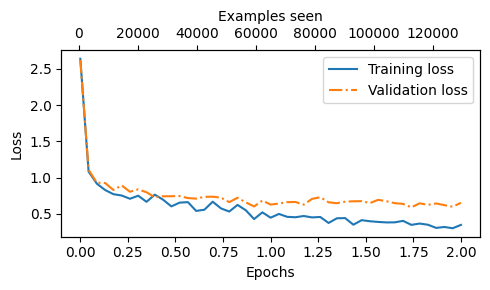

In [25]:
import matplotlib.pyplot as plt

# plotting function:
def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.show()


# plot:
epoch_tensor = torch.linspace(0, num_epochs, len(train_losses))
epoch_tensor = epoch_tensor.cpu()
train_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]
tokens_seen_cpu = [t.cpu().item() if isinstance(t, torch.Tensor) else t for t in tokens_seen]

plot_values(epoch_tensor.cpu(), tokens_seen, train_losses_cpu, val_losses_cpu)

The training looks quite good. Now, we can evaluate qualitatively by generating responses!

### Extracting and saving responses

We'll see how the fine-tuned LLM does on the first three test examples:

In [26]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):].replace("### Response:", "").strip()
    )

    print(f"Input text: {input_text}")
    print(f"\nCorrect response:\n>>{entry['output']}")
    print(f"\nModel response:\n>>{response_text.strip()}")
    print("-"*30)


Input text: Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>>The car is as fast as lightning.

Model response:
>>The car is as fast as a cheetah.
------------------------------
Input text: Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>>The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>>The type of cloud associated with thunderstorms is a cumulus.
------------------------------
Input text: Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>>Jane Austen.

Model response:
>>The author of 'Pri

Evaluating manually is laborious and time consuming. Here, we'll use an approach similar to automated conversational benchmarks, where another LLM is used to help evaluate the responses of our fine-tuned model. This example is inspired by [AlpacaEval](https://tatsu-lab.github.io/alpaca_eval/).

Let's begin by saving the model's generated responses alongside the data:

In [27]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text= (
        generated_text[len(input_text):].replace("### Response:", "").strip()
    )

    test_data[i]["model_response"] = response_text

100%|██████████| 110/110 [00:54<00:00,  2.02it/s]


See an example:

In [28]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a cheetah.'}

Save the updated file:

In [29]:
with open("instruction-data-with-response.json", "w") as f:
    json.dump(test_data, f, indent=4)

Let's also save our model for reuse:

In [30]:
import re
model_file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), model_file_name)
print(f"Model saved as: {model_file_name}")

Model saved as: gpt2-medium355M-sft.pth


### Evaluating the fine-tuned LLM

We'll assess our fine-tuned GPT-2 LLM using LLama 3 8B from [Ollama](https://ollama.com]). 

Use this shell script to download Ollama onto Linux:

```bash
curl -fsSL https://ollama.com/install.sh | sh
```

Make sure Ollama works by executing `ollama serve` from the terminal. 
- **Note:** you may need to change the port using something like `export OLLAMA_HOST=127.0.0.1:8080` depending on your server's configuration.

Then, open a new terminal and execute:

```bash
ollama run llama3
```
Now we can make sure Ollama is running:

In [31]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running! Make sure you launch Ollama before proceeding.")

print(f"Ollama running: {check_if_running('ollama')}")

Ollama running: True


Let's use the Ollama REST API:
- **Note:** some debugging and re-running of cells occurred to ensure I could get Ollama working properly on my VM.

In [40]:
import urllib.request

def query_model(
    prompt,
    model=model,
    url="http://localhost:8080/api/chat"
):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data

Test our function:

In [41]:
ollama_model = "llama3"
result = query_model("What do llamas eat?", ollama_model)
print(result)

Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: Hay is a staple in a llama's diet. They enjoy eating timothy hay, alfalfa hay, or other types of hay as a source of fiber and nutrients.
3. Grains: Llamas may be fed grains like oats, barley, or corn as an energy-rich snack.
4. Fruits and vegetables: Fresh fruits and vegetables can be given to llamas as treats or added to their diet for variety and nutrition. Some examples include apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas need access to minerals like calcium, phosphorus, and salt to maintain strong bones and overall health.

In the wild, llamas would typically roam in herds and eat whatever plants are available in their natural habitat. In captivity, llama owners often provide a balanced diet that

Now, let's run the evaluation against our test data:

In [42]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)} "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}` "
        f"on a scale from 0 to 100, where 100 is the best score."
    )

    print(f"\nDataset response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {entry['model_response']}")
    print(f"Llama 3 score:\n>> {query_model(prompt)}")
    print("\n")
    print("-"*50)


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
Llama 3 score:
>> I'd rate my own response a score of **95**.

Here's why:

* The original instruction asked for a simile (a comparison using "like" or "as") that describes the car's speed.
* My response, "The car is as fast as a cheetah," meets this requirement by comparing the car's speed to that of a cheetah, which is known for its incredible velocity.
* The only reason I wouldn't give myself a perfect score (100) is that there are other similes that could also effectively convey the idea of the car being very fast. For example, "The car is as fast as lightning" (as mentioned in the input). While my response is still a good one, it's not necessarily the most creative or unexpected comparison.

Overall, I'm happy with my score of 95!


--------------------------------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimb

Scoring works! We'll now generalize this:
- I'll also modify the prompt so Llama 3 doesn't think *it* generated the responses.
- We'll also trunacte the response to just the integer.

In [43]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entities", total=len(json_data)):
        prompt = (
            f"Given the input `{format_input(entry)} "
            f"and correct output `{entry['output']}`, "
            f"score the GPT-2 model's `{entry[json_key]}` "
            f"on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )

        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores

In [44]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entities:   4%|▎         | 4/110 [00:04<01:16,  1.39it/s]

Could not convert score: Jane Austen.
95


Scoring entities:  23%|██▎       | 25/110 [00:08<00:19,  4.29it/s]

Could not convert score: **Response:** Fish: Shark, Trout; Mammals: Dolphin

**Score:** 67


Scoring entities:  30%|███       | 33/110 [00:09<00:16,  4.72it/s]

Could not convert score: Here is the rewritten sentence:

It's very easy.

Score: 80


Scoring entities:  41%|████      | 45/110 [00:11<00:17,  3.66it/s]

Could not convert score: Here is the response:

The transient nature of her visit left a lasting impression.

Score: 20


Scoring entities:  43%|████▎     | 47/110 [00:12<00:18,  3.45it/s]

Could not convert score: Here is the response:

He remained optimistic despite the challenges he faced.

Score: 95


Scoring entities:  55%|█████▌    | 61/110 [00:14<00:07,  6.50it/s]

Could not convert score: Opinion-based.
85


Scoring entities:  61%|██████    | 67/110 [00:15<00:10,  4.02it/s]

Could not convert score: The three forms of water are solid (ice), liquid (water), and gas (steam).

Score: 60


Scoring entities:  72%|███████▏  | 79/110 [00:17<00:08,  3.62it/s]

Could not convert score: Here is the response:

**Classification:** Swim: Verb, Beautiful: Adjective, Quickly: Adverb

**Score:** 100


Scoring entities: 100%|██████████| 110/110 [00:22<00:00,  4.94it/s]

Number of scores: 102 of 110
Average score: 65.87



We did it! 